In [82]:
import yt
import unyt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [83]:
import os
import sys

# Required to guarantee that the 'src' module is accessible when
# this file is run directly.
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

In [84]:
from typing import Any, Callable, List, Tuple

In [256]:
from src.calc import std_dev, overdensity, mass_function, press_schechter, rho_bar
from src.fitting import fits
from src.plotting import Plotter

In [86]:
from src.util.init import setup

CONF="configs/press_schechter.yaml"

d = setup.setup([CONF])

caches:
  use_fits_cache: true
  use_masses_cache: true
  use_overdensities_cache: true
  use_press_schechter_cache: false
  use_rho_bar_0_cache: true
  use_rho_bar_cache: true
  use_sphere_samples: true
  use_standard_deviation_cache: false
  use_total_cache: true
datatypes:
  groups: false
  halos_h5: true
  rockstar: false
  snapshots: true
from_z: 6
plotting:
  dirs:
    compared: '{}/{}/compared/'
    extrapolated_gaussian_fit: '{}/{}/extrapolated_gaussian_fit/'
    gaussian_fit: '{}/{}/gaussian_fit/'
    mass_function: '{}/{}/mass_function/'
    n_gaussian_fit: '{}/{}/n_gaussian_fit/'
    numerical_mass_function: '{}/{}/numerical_mass_function/{}/'
    overdensity: '{}/{}/deltas/'
    press_schechter: '{}/{}/press_schechter/'
    root: ../plots/
    skewed_gaussian_fit: '{}/{}/skewed_gaussian_fit/'
    std_dev: '{}/{}/std_dev/'
    total: '{}/{}/total_mass_function/'
  fitting:
    num_n_gaussian_fits: 10
  pattern:
    compared_analytic: analytic_mass_function_comparison_z{:.2f}

In [87]:
from src.util.constants import DELTA_CRIT

In [241]:
def analytic_press_schechter(avg_den: float, masses: List[float], sigmas: List[float]):
    frac = np.abs(sigmas / masses).value

    press_schechter = np.sqrt(2 / np.pi) * (DELTA_CRIT / sigmas**2) * (
        avg_den / masses) * frac * np.exp(-DELTA_CRIT**2 / (2 * sigmas**2))

    return press_schechter

In [245]:
from scipy import integrate
from src.fitting import funcs

def numerical_mass_function(avg_den: float, radii: List[float], masses: List[List[float]], fitting_func: Callable, func_params):

    F = []

    for i in range(len(radii)):
        popt = func_params[i]

        def f(x):
            y = fitting_func(x, *popt)
            return funcs.filter_val(y)

        integrand, err = integrate.quad(f, DELTA_CRIT, np.inf)
        F.append(integrand)

    dF_dR = np.abs(np.gradient(F, radii))

    dR_dM = np.abs(np.gradient(radii, masses))

    dF_dM = dF_dR * dR_dM

    dn_dM = dF_dM * avg_den / masses

    return dn_dM


In [246]:
def _mass_function(x, y, label: str = None, fig=None):
    if len(x) == 0 or len(y) == 0:
        print("Attempting to plot empty data!")
        return

    autosave = fig is None
    if autosave:
        fig = plt.figure()
    ax = fig.gca()

    # Filter values:
    y = np.round(y, decimals=100)
    non_zero = (y != 0)
    y = y[non_zero]
    x = x[non_zero]

    ax.plot(x, y, label=label)
    ax.set_xscale("log")
    ax.set_yscale("log")

    if label is not None:
        ax.legend()

    ax.set_xlabel("M ($M_\odot$/h)")
    ax.set_ylabel("$\phi=\\frac{d n}{d M}$")

    return fig


In [90]:
from src.util.enum import DataType

In [91]:
sim_name = d.config.sim_data.simulation_names[0]

In [92]:
sd = std_dev.StandardDeviation(d, DataType.SNAPSHOT, sim_name)

In [247]:
rb = rho_bar.RhoBar(d, DataType.SNAPSHOT, sim_name)

In [257]:
fitter = fits.Fits(d, DataType.SNAPSHOT, sim_name)

In [249]:
plotter = Plotter(d, DataType.SNAPSHOT, sim_name)

In [252]:
od = overdensity.Overdensity(d, DataType.SNAPSHOT, sim_name)

In [253]:
mf = mass_function.MassFunction(d, DataType.H5, sim_name)

In [254]:
ps = press_schechter.PressSchechter(d, DataType.SNAPSHOT, sim_name)

In [93]:
from src.util.halos import halo_finder

finder = halo_finder.HalosFinder(DataType.SNAPSHOT, d.config.sim_data.root, sim_name)

hfs = finder.filter_data_files([0, 6, 99])

In [94]:
hfs

['/disk12/legacy/GVD_C700_l1600n2048_SLEGAC/dm_gadget/data/snapdir_101/snapshot_101.0.hdf5',
 '/disk12/legacy/GVD_C700_l1600n2048_SLEGAC/dm_gadget/data/snapdir_037/snapshot_037.0.hdf5',
 '/disk12/legacy/GVD_C700_l1600n2048_SLEGAC/dm_gadget/data/snapdir_000/snapshot_000.0.hdf5']

In [95]:
hf_0, hf_6, hf_99 = hfs

In [96]:
ds = d.dataset_cache.load(hf_0)
z = ds.current_redshift

In [97]:
masses, sigmas = sd.masses_sigmas(
                hf_0, from_fit=False)

In [250]:
avg_den_0 = rb.rho_bar(hf_0)

In [251]:
from src.util import units as u
ps_fit = analytic_press_schechter(avg_den_0, masses, sigmas).to(1 / u.volume(ds))

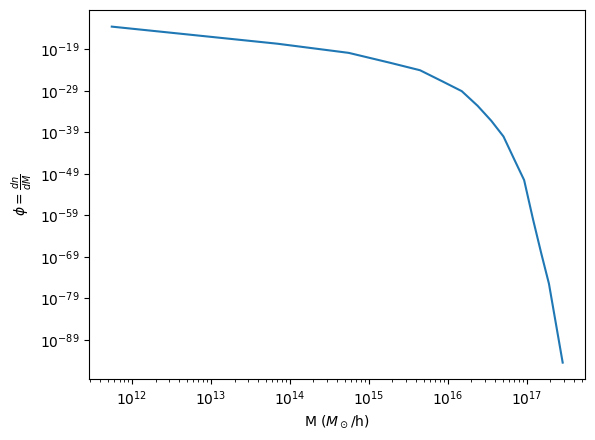

In [103]:
fig = plt.figure()

_mass_function(masses, ps_fit, fig=fig);

# STD DEVS EXTRAPOLATION

In [104]:
stds_99 = sd.extrapolated(99, 0, from_fit=False);

In [105]:
stds_6 = sd.extrapolated(6, 0, from_fit=False)

In [106]:
avg_den_6 = rb.rho_bar(hf_6)

In [107]:
avg_den_99 = rb.rho_bar(hf_99)

In [108]:
ps_fit_99 = analytic_press_schechter(avg_den_99, masses, stds_99).to(1 / u.volume(ds))

In [109]:
ps_fit_6 = analytic_press_schechter(avg_den_6, masses, stds_6).to(1 / u.volume(ds))

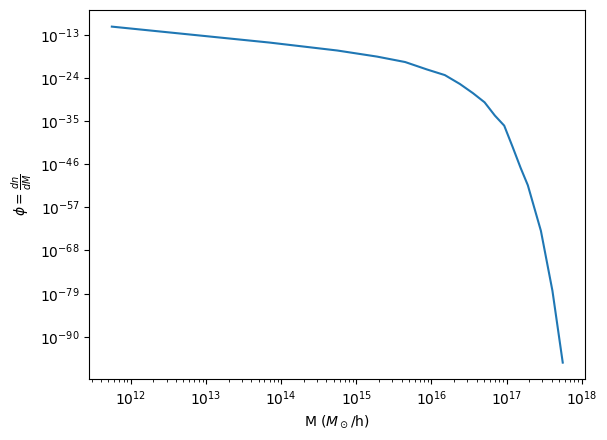

In [110]:
fig = plt.figure()

_mass_function(masses, ps_fit_6, fig=fig);

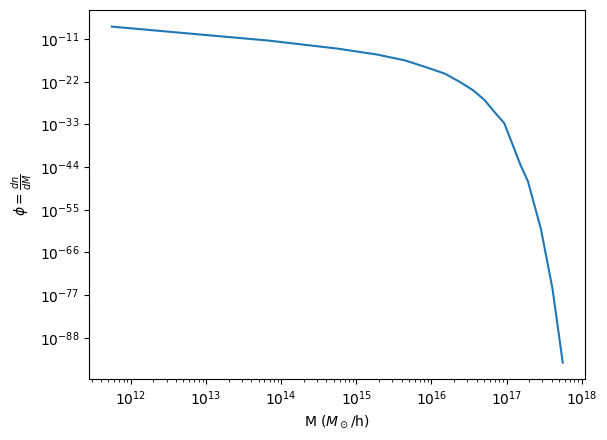

In [111]:
fig = plt.figure()

_mass_function(masses, ps_fit_99, fig=fig);

# Composite

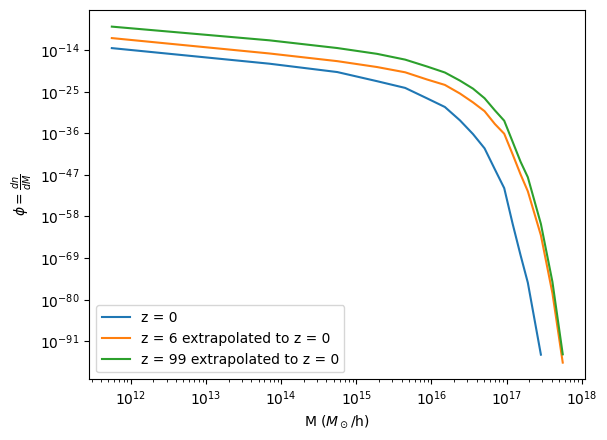

In [112]:
fig = plt.figure()

_mass_function(masses, ps_fit, fig=fig, label="z = 0");
_mass_function(masses, ps_fit_6, fig=fig, label="z = 6 extrapolated to z = 0");
_mass_function(masses, ps_fit_99, fig=fig, label="z = 99 extrapolated to z = 0");


In [113]:
fig.savefig("../plots/GVD_C700_l1600n2048_SLEGAC/snapshots/extrapolated_press_schechters.png")

[-3.10173281e+02 -3.50597488e+02 -5.30353820e+02 -3.82258712e+03
 -9.35048868e+03 -6.71038189e+04 -4.77346459e+05 -8.65887132e+06
 -1.67553312e+08 -4.66078222e+09 -6.83487088e+11 -1.68599019e+14
 -1.73882204e+18 -1.62465078e+21 -1.00507280e+24 -2.48349208e+31
 -6.00820399e+41 -5.90069959e+56] dimensionless


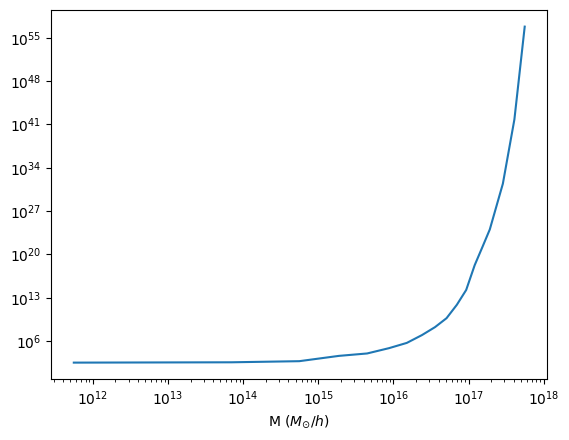

In [219]:
residual_0v6 = (ps_fit - ps_fit_6) / ps_fit

fig = plt.figure()
ax = fig.gca()

ax.plot(masses, abs(residual_0v6))
ax.set_xscale("log")
ax.set_xlabel("M ($M_{\odot}/h$)")
ax.set_yscale("log")

print(residual_0v6)

fig.savefig("../plots/GVD_C700_l1600n2048_SLEGAC/snapshots/residuals.png")

In [119]:
num_bins = d.config.sampling.num_hist_bins

# NUMERICAL MASS FUNCTIONS

In [120]:
numericals = {}

for func_name, fitting_func in fitter.fit_functions().items():
    # Set the fitting function to use
    plotter.func = fitting_func
    # Track the fitting parameters across radii
    func_params = []

    # Iterate over the radii
    radii = d.config.radii
    for radius in radii:

        # Calculate the overdensities at this sampling radius
        od = ods.calc_overdensities(hf_0, radius)

        # Get the fitting parameters to this overdensity
        fitter.setup_parameters(func_name)
        _, _, _, popt = fitter.calc_fit(
            z, radius, od, num_bins)

        # Track the fitting parameters
        func_params.append(popt)

    # Calculate the numerical mass function for this fit model
    numerical_mass_function = ps.numerical_mass_function(
        avg_den_0, radii, masses, fitting_func, func_params)
    
    numericals[func_name] = numerical_mass_function

/home/tstapleton/dissertation/code/src/calc/press_schechter.py:36: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrand, err = integrate.quad(f, DELTA_CRIT, np.inf)
/home/tstapleton/dissertation/code/src/calc/press_schechter.py:36: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integrand, err = integrate.quad(f, DELTA_CRIT, np.inf)


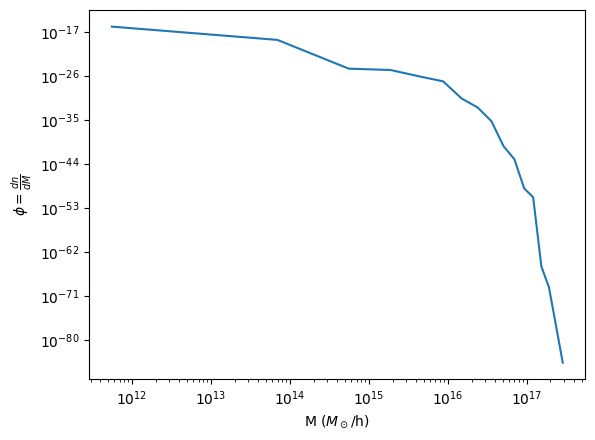

In [121]:
_mass_function(masses, numericals["gaussian"]);

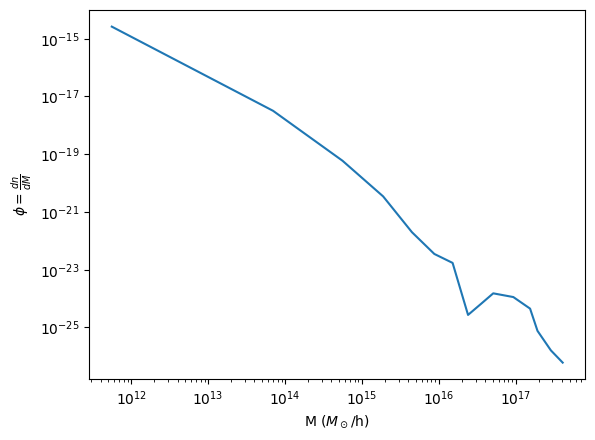

In [122]:
_mass_function(masses, numericals["skew_gaussian"]);

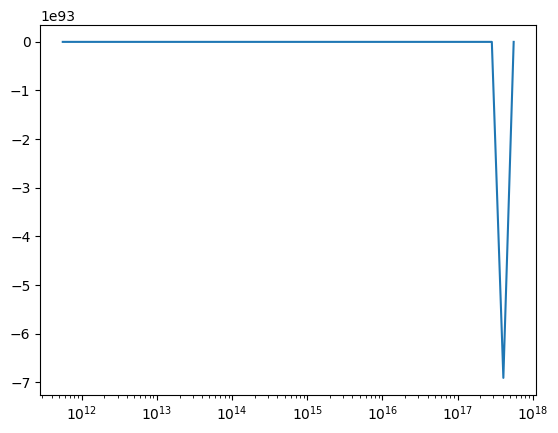

In [258]:
residuals_skew_ps = (ps_fit - numericals["skew_gaussian"]) / ps_fit

f = plt.figure()
a = f.gca()
a.plot(masses, residuals_skew_ps)
a.set_xscale("log")

# GET TOTAL HIST VALUES

In [129]:
import pickle

fname="/home/tstapleton/dissertation/data/GVD_C700_l1600n2048_SLEGAC/halos_h5/total_hist/0.0.pickle"
with open(fname, "rb") as f:
    tup = pickle.load(f)

total_hist, total_bins = tup

In [130]:
total_bins

array([7.54300000e+10, 5.20446757e+13, 1.04013921e+14, 1.55983167e+14,
       2.07952413e+14, 2.59921658e+14, 3.11890904e+14, 3.63860150e+14,
       4.15829396e+14, 4.67798641e+14, 5.19767887e+14, 5.71737133e+14,
       6.23706378e+14, 6.75675624e+14, 7.27644870e+14, 7.79614116e+14,
       8.31583361e+14, 8.83552607e+14, 9.35521853e+14, 9.87491098e+14,
       1.03946034e+15, 1.09142959e+15, 1.14339884e+15, 1.19536808e+15,
       1.24733733e+15, 1.29930657e+15, 1.35127582e+15, 1.40324506e+15,
       1.45521431e+15, 1.50718356e+15, 1.55915280e+15, 1.61112205e+15,
       1.66309129e+15, 1.71506054e+15, 1.76702978e+15, 1.81899903e+15,
       1.87096828e+15, 1.92293752e+15, 1.97490677e+15, 2.02687601e+15,
       2.13081450e+15, 2.18278375e+15, 2.23475300e+15, 2.28672224e+15,
       2.33869149e+15, 2.44262998e+15, 2.49459922e+15, 2.54656847e+15,
       2.59853772e+15, 2.70247621e+15, 2.80641470e+15, 2.85838394e+15,
       3.74186112e+15, 4.05367659e+15, 5.14503075e+15])

In [131]:
min_total = min(total_bins)
max_total = max(total_bins)

In [132]:
min_idxs = np.where(masses < max_total)

In [133]:
residuals_skew_ps = residuals_skew_ps[min_idxs]
filtered_masses = masses[min_idxs]

In [134]:
max_idxs = np.where(filtered_masses > min_total)
residuals_skew_ps = residuals_skew_ps[max_idxs]
filtered_masses = filtered_masses[max_idxs]

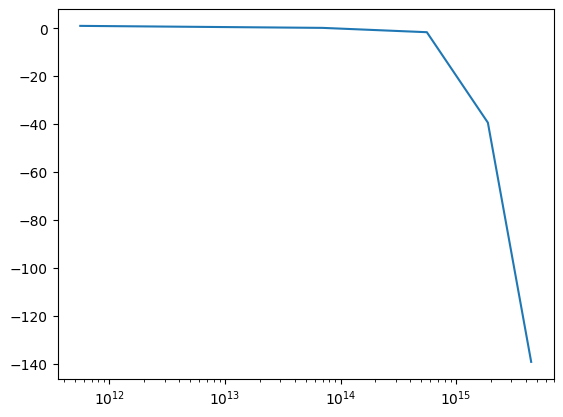

In [135]:
fig = plt.figure()
ax = fig.gca()

ax.plot(filtered_masses, residuals_skew_ps)
ax.set_xscale("log")

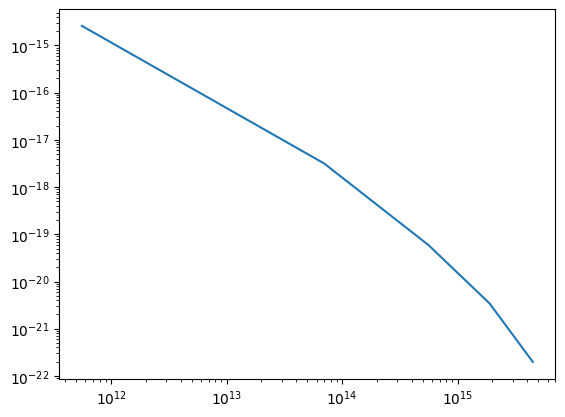

In [136]:
filtered_skew = numericals["skew_gaussian"][min_idxs][max_idxs]

fig = plt.figure()
ax = fig.gca()
ax.plot(filtered_masses, filtered_skew)
ax.set_xscale("log")
ax.set_yscale("log")

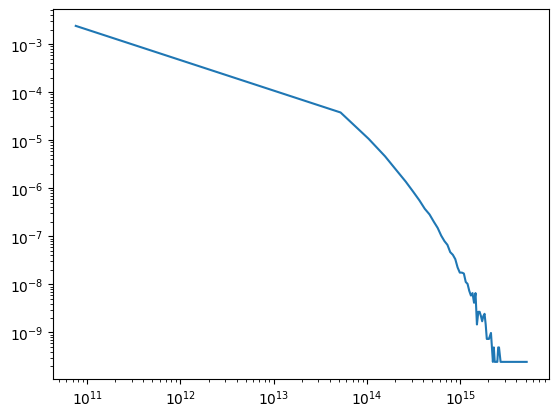

In [137]:
fig = plt.figure()
ax = fig.gca()
ax.plot(total_bins, total_hist)
ax.set_xscale("log")
ax.set_yscale("log")

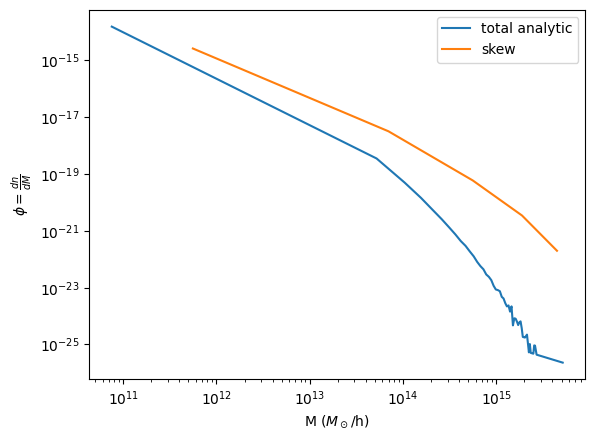

In [259]:
fig = plt.figure()
_mass_function(total_bins, total_hist / total_bins, label="total analytic", fig=fig);
_mass_function(filtered_masses, filtered_skew, label="skew", fig=fig);

# Compare Numerical Gaussian to PS:

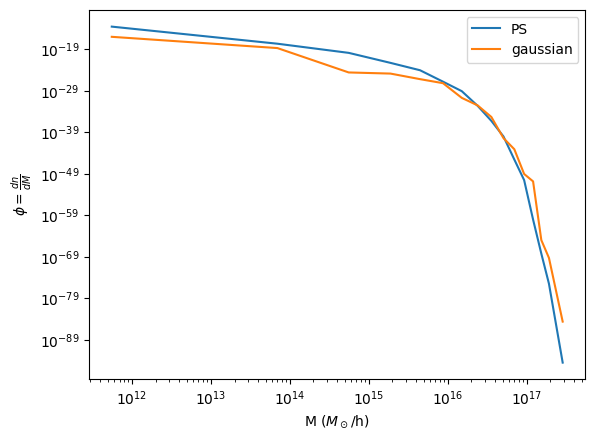

In [139]:
fig = plt.figure()
_mass_function(masses, ps_fit, label="PS", fig=fig);
_mass_function(masses, numericals["gaussian"], label="gaussian", fig=fig);

# FUDGING?

In [140]:
total_max_y = max(total_hist)
total_min_y = min(total_hist)
total_max_x = max(total_bins)
total_min_x = min(total_bins)
print("X BOUNDS=10^", np.log10(total_min_x), "< x < 10^", np.log10(total_max_x))
print("Y BOUNDS=", total_min_y, "< y <", total_max_y)

X BOUNDS=10^ 10.877544107715945 < x < 10^ 15.711387975091235
Y BOUNDS= 2.4414062499999994e-10 h**3/Mpc**3 < y < 0.0023911210937499995 h**3/Mpc**3


In [141]:
calibrated_ps = ps_fit / ps_fit[0] * total_hist[0]
calibrated_ps

unyt_array([1.15497127e-003, 8.74560026e-008, 5.39178159e-010,
            2.09378370e-012, 3.46888696e-014, 6.08003492e-017,
            3.15023105e-019, 9.17757526e-023, 2.12325170e-026,
            3.65697139e-030, 1.01098997e-035, 1.10732121e-040,
            3.31183635e-050, 2.04137146e-058, 1.13199035e-065,
            1.04348866e-084, 2.15180168e-110, 9.71877448e-144], 'h/Mpc**3')

In [142]:
valid_ranges_max = np.where(np.logical_and(calibrated_ps < total_max_y, calibrated_ps > total_min_y))

In [143]:
calibrated_ps = calibrated_ps[valid_ranges_max]
calibrated_masses = masses[valid_ranges_max]

In [144]:
valid_ranges_min = np.where(calibrated_ps > total_min_y)
calibrated_ps = calibrated_ps[valid_ranges_min]
calibrated_masses = calibrated_masses[valid_ranges_min]

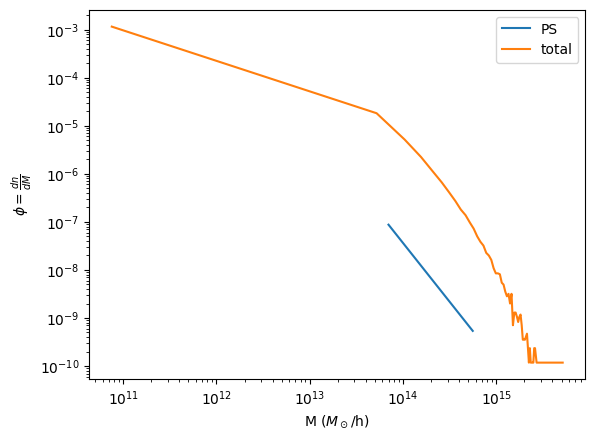

In [145]:
fig = plt.figure()
_mass_function(calibrated_masses, calibrated_ps, fig=fig, label="PS");
_mass_function(total_bins, total_hist, label="total", fig=fig);

In [146]:
masses

unyt_array([5.58579400e+11, 6.98224249e+13, 5.58579400e+14,
            1.88520547e+15, 4.46863520e+15, 8.72780312e+15,
            1.50816438e+16, 2.39490918e+16, 3.57490816e+16,
            5.09005478e+16, 6.98224249e+16, 9.29336476e+16,
            1.20653150e+17, 1.53399868e+17, 1.91592734e+17,
            2.85992653e+17, 4.07204382e+17, 5.58579400e+17], 'Msun/h')

In [147]:
sigmas

array([2.98445027, 1.33863553, 0.79605145, 0.4933453 , 0.41145643,
       0.32273131, 0.28137679, 0.23682987, 0.20739586, 0.18593236,
       0.16312915, 0.14861327, 0.12862674, 0.11666339, 0.10848625,
       0.09310919, 0.07991773, 0.0689652 ])

In [148]:
max_total_mass = max(total_bins)
relevant_idxs = np.where(masses < max_total_mass)

relevant_masses = masses[relevant_idxs]
relevant_sigmas = sigmas[relevant_idxs]

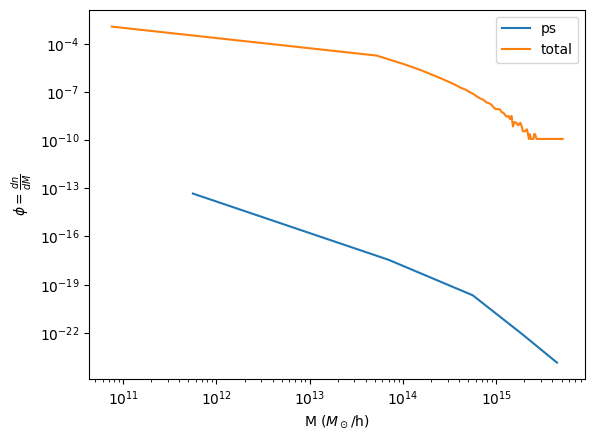

In [149]:
relevant_press = analytic_press_schechter(avg_den_0, relevant_masses, relevant_sigmas)

fig = plt.figure()
_mass_function(relevant_masses, relevant_press, fig=fig, label="ps");
_mass_function(total_bins, total_hist, fig=fig, label="total");

In [150]:
# frac = np.abs(sigmas / masses).value

# ps = np.sqrt(2 / np.pi) * (DELTA_CRIT / sigmas**2) * (
#      avg_den_0 / masses) * frac * np.exp(-DELTA_CRIT**2 / (2 * sigmas**2))

ps = np.sqrt(2 / np.pi) * (DELTA_CRIT / sigmas**2) * (
     avg_den_0 / masses) * np.exp(-DELTA_CRIT**2 / (2 * sigmas**2))
#     press_schechter = np.sqrt(2 / np.pi) * (DELTA_CRIT / sigmas**2) * (
#         avg_den) * frac * np.exp(-DELTA_CRIT**2 / (2 * sigmas**2))

# print("FRAC")
# print(frac)
print("PS")
print(ps)

PS
[8.80625318e-003 1.85832480e-004 1.54125851e-005 3.25940952e-007
 1.53476052e-008 6.69837313e-011 6.87863453e-013 3.78076735e-016
 1.49095905e-019 4.07838720e-023 1.76282673e-028 2.82090489e-033
 1.26553951e-042 1.09348254e-050 8.14416366e-058 1.30571827e-076
 4.46653715e-102 3.20675532e-135] h/Mpc**3


In [151]:
print(total_hist)

[2.39112109e-03 3.77312012e-05 1.06853027e-05 4.62402344e-06
 2.33032227e-06 1.37402344e-06 8.51562500e-07 5.61767578e-07
 3.74267578e-07 2.85400391e-07 2.01171875e-07 1.49658203e-07
 1.03515625e-07 7.95898437e-08 6.64062500e-08 4.68750000e-08
 4.12597656e-08 3.34472656e-08 2.24609375e-08 1.75781250e-08
 1.75781250e-08 1.68457031e-08 1.12304687e-08 1.02539062e-08
 7.32421875e-09 5.85937500e-09 6.59179687e-09 4.15039062e-09
 6.59179687e-09 1.46484375e-09 2.68554687e-09 2.68554687e-09
 2.19726562e-09 1.70898437e-09 2.19726562e-09 2.44140625e-09
 1.46484375e-09 7.32421875e-10 7.32421875e-10 7.32421875e-10
 9.76562500e-10 4.88281250e-10 2.44140625e-10 4.88281250e-10
 2.44140625e-10 2.44140625e-10 2.44140625e-10 4.88281250e-10
 4.88281250e-10 2.44140625e-10 2.44140625e-10 2.44140625e-10
 2.44140625e-10 2.44140625e-10 2.44140625e-10] h**3/Mpc**3


In [152]:
ranges_min = np.where(ps > 1e-11)

In [153]:
ranges_min

(array([0, 1, 2, 3, 4, 5]),)

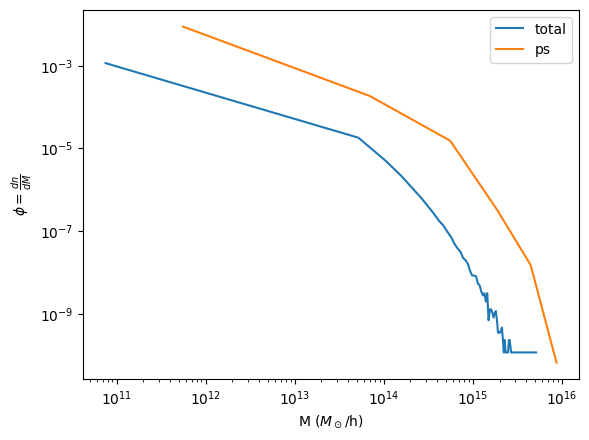

In [154]:
fig=plt.figure()
_mass_function(total_bins, total_hist, label="total", fig=fig);
_mass_function(masses[ranges_min], ps[ranges_min], label="ps", fig=fig);

# Gaussian compared to PS

In [238]:
def residual(x1, y1, x2, y2, l1, l2, savename):
    fig = plt.figure()

    gs = fig.add_gridspec(2, 1)

    fig1 = fig.add_subfigure(gs[0,0])
    _mass_function(x1, y1, label=l1, fig=fig1);
    _mass_function(x2, y2, label=l2, fig=fig1);

    residual = (y1 - y2) / y1

    fig2 = fig.add_subfigure(gs[1,0])

    prev_ax=fig1.gca()
    ax = fig2.add_subplot(sharex=prev_ax)
    ax.plot(x1, abs(residual))
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlabel("M ($M_{\odot}$/h)")
    ax.set_ylabel("residual = $\\frac{\phi_1-\phi_2}{\phi_1}$")

    fig.savefig(savename)

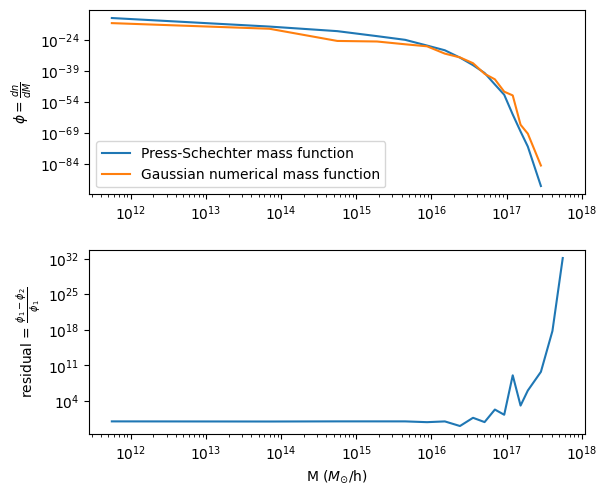

In [240]:
residual(masses, ps_fit, masses, numericals["gaussian"], "Press-Schechter mass function", "Gaussian numerical mass function", "../plots/GVD_C700_l1600n2048_SLEGAC/snapshots/residuals_gaussian.png")

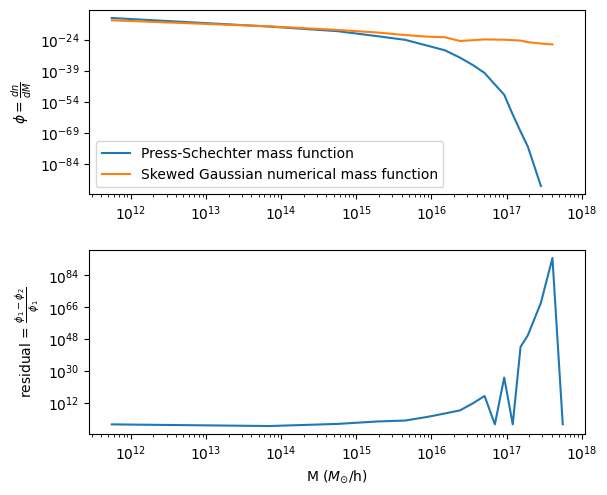

In [239]:
residual(masses, ps_fit, masses, numericals["skew_gaussian"], "Press-Schechter mass function", "Skewed Gaussian numerical mass function", "../plots/GVD_C700_l1600n2048_SLEGAC/snapshots/residuals_skew_gaussian.png")

ValueError: operands could not be broadcast together with shapes (18,) (55,) 

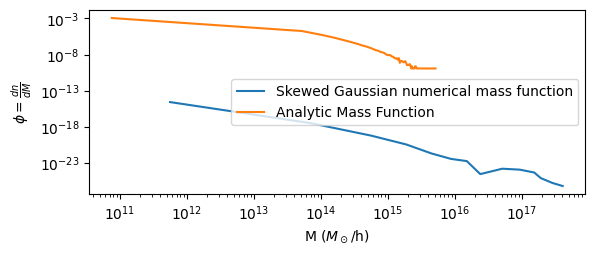

In [262]:
residual(masses, numericals["skew_gaussian"], total_bins, total_hist, "Skewed Gaussian numerical mass function", "Analytic Mass Function", "../plots/GVD_C700_l1600n2048_SLEGAC/snapshots/residuals_skew_gaussian_total_z0.png")

In [290]:
volume = (ds.domain_width[0].to(u.length(ds)))**3

In [291]:
unhist = []
for h,b in zip(total_hist, total_bins):
    H = h * volume
    vals = [b for _ in range(round(H))]
    for a in vals:
        unhist.append(a)

unhist = unyt.unyt_array(unhist, u.mass(ds))

In [280]:
unhist

unyt_array([7.54300000e+10, 7.54300000e+10, 7.54300000e+10, ...,
            3.74186112e+15, 4.05367659e+15, 5.14503075e+15], 'Msun/h')

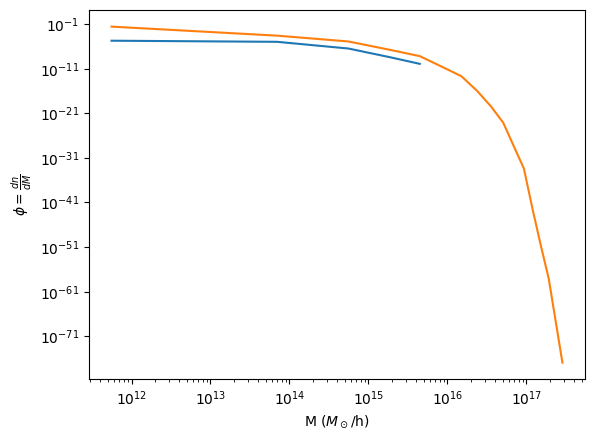

In [293]:
hist, bins = np.histogram(unhist, bins=masses)

fig = plt.figure()
_mass_function(bins[:-1], hist / volume, fig=fig);
_mass_function(masses, ps_fit * masses, fig=fig);

In [302]:
ps_rescaled = ps_fit / ps_fit[0] * (hist / volume)[0]

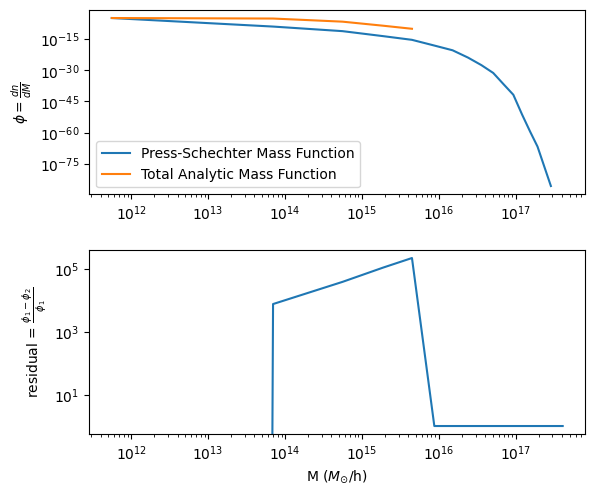

In [304]:
residual(masses[:-1], ps_rescaled[:-1], bins[:-1], hist / volume, "Press-Schechter Mass Function", "Total Analytic Mass Function", "../plots/GVD_C700_l1600n2048_SLEGAC/snapshots/residual_total_v_ps.png")

In [307]:
skew_rescale = numericals["skew_gaussian"] / numericals["skew_gaussian"][0] * (hist / volume)[0]

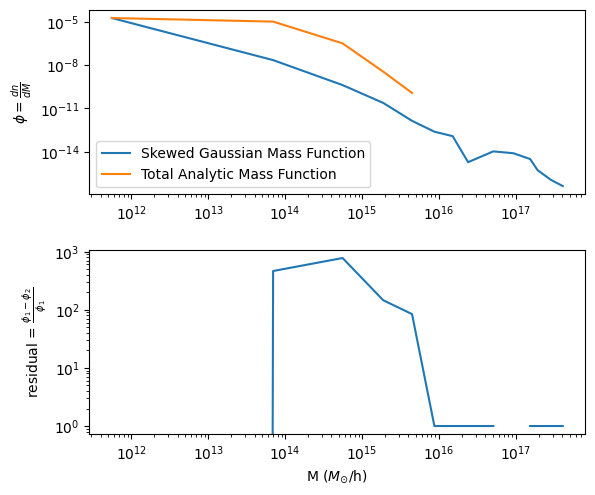

In [308]:
residual(masses[:-1], skew_rescale[:-1], bins[:-1], hist / volume, "Skewed Gaussian Mass Function", "Total Analytic Mass Function", "../plots/GVD_C700_l1600n2048_SLEGAC/snapshots/residual_total_v_skew.png")